In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
sns.set_style('whitegrid')

##Import any other packages you may need here
from glob import glob

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
df = pd.read_csv('sample_labels.csv')
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


### Getting a first look into the dataframe composition

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


In [4]:
df.isnull().sum()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImageWidth             0
OriginalImageHeight            0
OriginalImagePixelSpacing_x    0
OriginalImagePixelSpacing_y    0
dtype: int64

No null fields as suspected

In [5]:
for column in df.columns:
    print(f'{column}:  {df[column].value_counts().shape[0]} values')

Image Index:  5606 values
Finding Labels:  244 values
Follow-up #:  113 values
Patient ID:  4230 values
Patient Age:  92 values
Patient Gender:  2 values
View Position:  2 values
OriginalImageWidth:  362 values
OriginalImageHeight:  341 values
OriginalImagePixelSpacing_x:  9 values
OriginalImagePixelSpacing_y:  9 values


In [6]:
df['Patient Gender'].unique()

array(['M', 'F'], dtype=object)

In [7]:
df['View Position'].unique()

array(['AP', 'PA'], dtype=object)

## Dataset distributions

Process Patient Age column for them to be numbers instead of strings

In [8]:
df['Patient Age'] = df['Patient Age'].apply(lambda x: int(x[0:-1]))

In [9]:
def plot_distributions(dists, cols=4):
    cols = min(len(dists), cols)
    rows = len(dists) // cols + (1 if len(dists) % cols != 0 else 0)
    
    _, axes = plt.subplots(rows, cols, sharey=True, figsize=(10 * cols, 7 * rows))
    axes = axes.flatten()
    for i, dist in enumerate(dists):
        sns.distplot(dist['data'], ax=axes[i]).set_title(dist['title'])

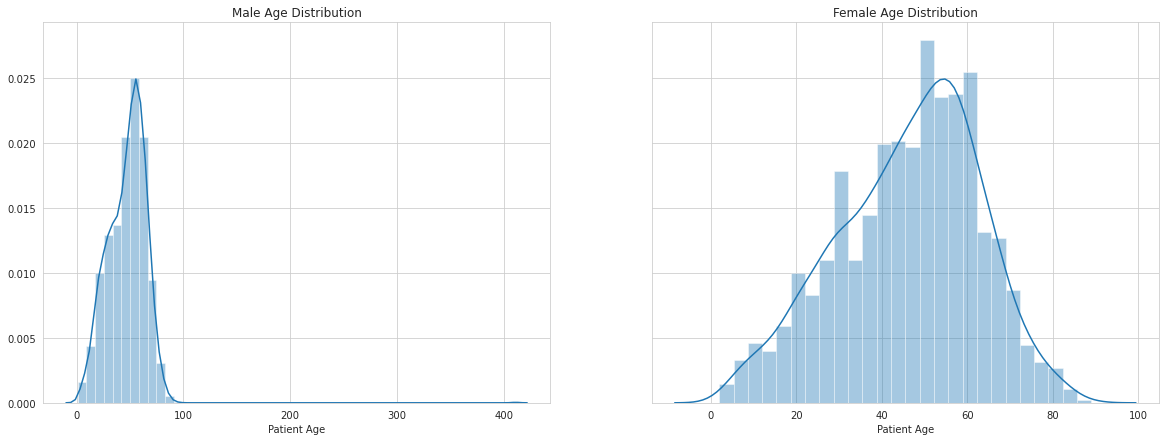

In [10]:
plot_distributions([
    { 'data': df[df['Patient Gender'] == 'M']['Patient Age'], 'title': 'Male Age Distribution' },
    { 'data': df[df['Patient Gender'] == 'F']['Patient Age'], 'title': 'Female Age Distribution' }
])

In [11]:
df[df['Patient Age'] > 100]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4242,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139


Since there is only a patient above 100 years old, it is going to be ignore since it is most certanly a mistake.

In [12]:
df = df.drop([4242])

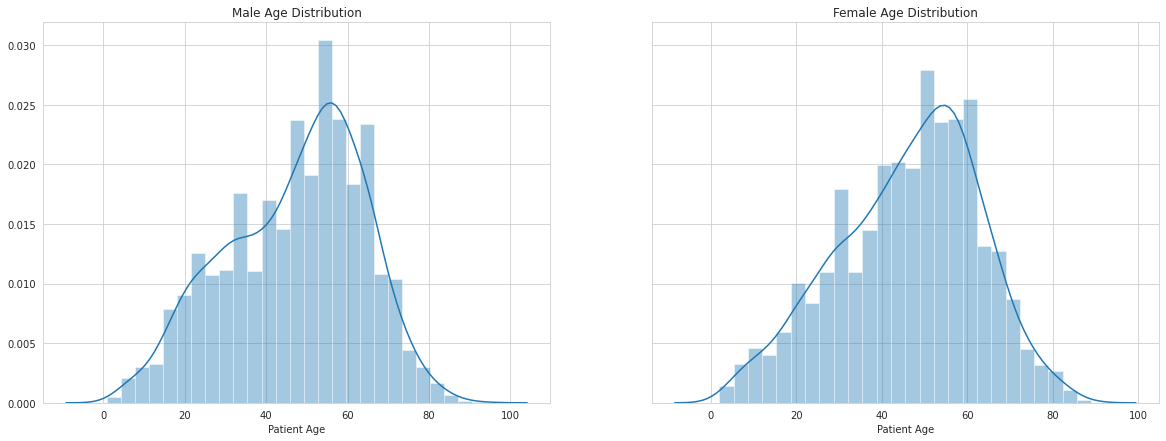

In [13]:
plot_distributions([
    { 'data': df[df['Patient Gender'] == 'M']['Patient Age'], 'title': 'Male Age Distribution' },
    { 'data': df[df['Patient Gender'] == 'F']['Patient Age'], 'title': 'Female Age Distribution' }
])

In [14]:
df['Finding Labels'].value_counts()

No Finding                                        3043
Infiltration                                       503
Effusion                                           203
Atelectasis                                        192
Nodule                                             144
                                                  ... 
Edema|Nodule                                         1
Atelectasis|Effusion|Mass|Pleural_Thickening         1
Effusion|Emphysema|Pleural_Thickening                1
Cardiomegaly|Mass                                    1
Edema|Infiltration|Mass|Pneumonia|Pneumothorax       1
Name: Finding Labels, Length: 244, dtype: int64

List all pathologies in one variable and update dataframe to ease data search

In [15]:
findings = df['Finding Labels'].values
pathologies = []

for finding in findings:
    found_pathologies = finding.split('|')
    for pathology in found_pathologies:
        # Check if pathology is already listed
        if pathology in pathologies: continue
        # Add pathology to array
        pathologies.append(pathology)

In [16]:
for pathology in pathologies:
    df[pathology] = df['Finding Labels'].apply(lambda x: pathology in x)

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,No Finding,Atelectasis,Edema,Effusion,Consolidation,Mass,Nodule,Fibrosis,Pneumonia,Hernia
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60,M,AP,3056,2544,0.139,...,False,False,False,False,False,False,False,False,False,False
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,57,M,AP,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,False
2,00000017_001.png,No Finding,1,17,77,M,AP,2500,2048,0.168,...,True,False,False,False,False,False,False,False,False,False
3,00000030_001.png,Atelectasis,1,30,79,M,PA,2992,2991,0.143,...,False,True,False,False,False,False,False,False,False,False
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,...,False,False,True,True,False,False,False,False,False,False


In [17]:
def plot_bar(bar, title):
    _, ax = plt.subplots(sharex=True, figsize=(30, 10))
    
    sns.barplot(data=bar, ax=ax).set_title(title)
    sns.despine(left=True)

Text(0.5, 1.0, 'Sick and Healthy Patients by Gender')

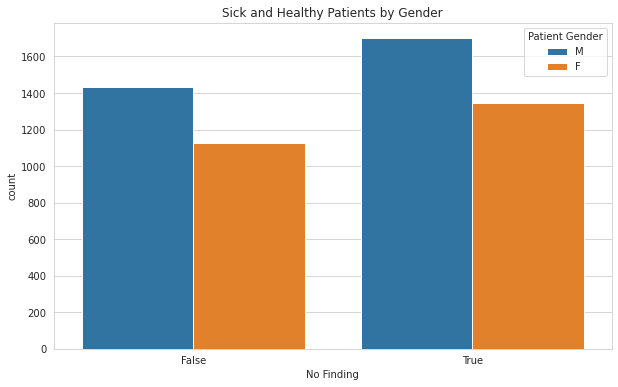

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x='No Finding', hue='Patient Gender', data=df).set_title('Sick and Healthy Patients by Gender')

Text(0.5, 1.0, 'Most Common Deseases')

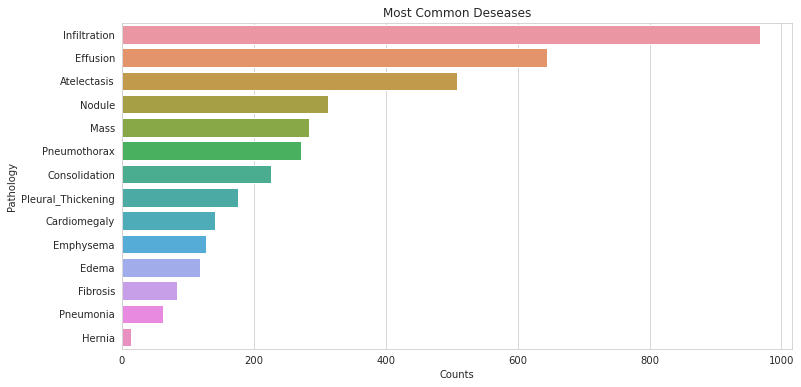

In [19]:
common_deseases = { 'Pathology': [], 'Counts': [] }
for pathology in pathologies:
    if pathology == 'No Finding': continue
    common_deseases['Pathology'].append(pathology)
    common_deseases['Counts'].append(len(df[df[pathology] == True]))

common_deseases_df = pd.DataFrame(common_deseases).sort_values(by=['Counts'], ascending=False)

fig = plt.figure(figsize=(12, 6))
sns.barplot(x='Counts', y='Pathology', data=common_deseases_df).set_title('Most Common Deseases')

_______________________________________

## Image Display

Compute the path of every image in the Dataframe

In [20]:
df['Path'] = df['Image Index'].apply(lambda x: glob(f'/data/images*/*/{x}')[0])
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Atelectasis,Edema,Effusion,Consolidation,Mass,Nodule,Fibrosis,Pneumonia,Hernia,Path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60,M,AP,3056,2544,0.139,...,False,False,False,False,False,False,False,False,False,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,57,M,AP,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,77,M,AP,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,79,M,PA,2992,2991,0.143,...,True,False,False,False,False,False,False,False,False,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,...,False,True,True,False,False,False,False,False,False,/data/images_001/images/00000032_001.png


Display images for each pathology including those with no findings.

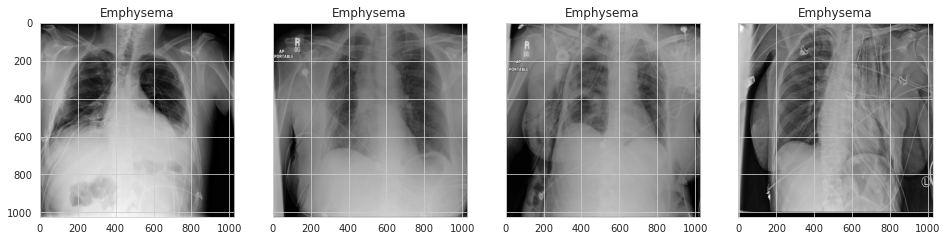

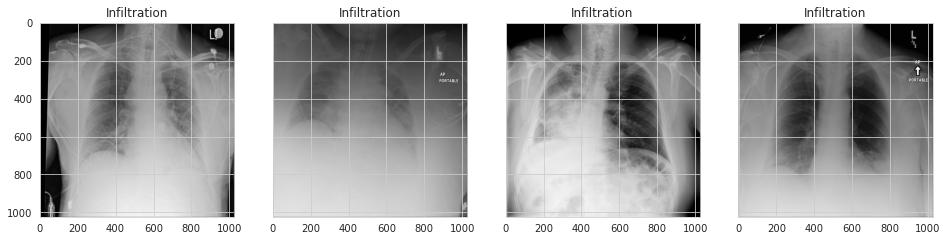

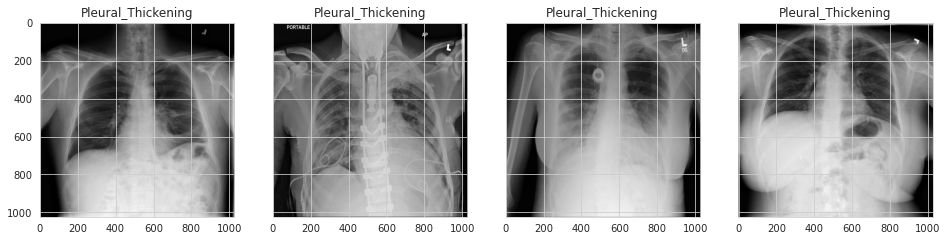

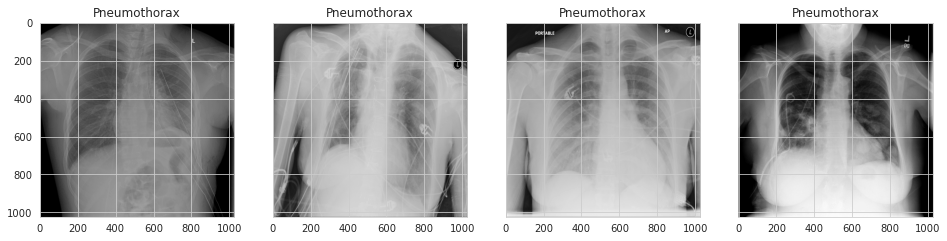

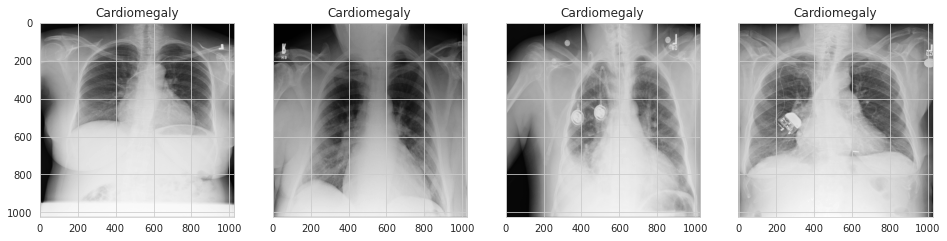

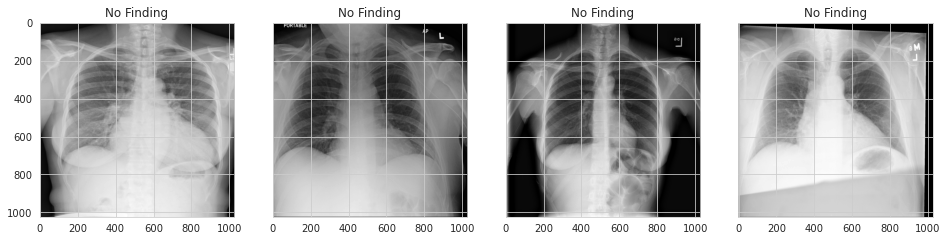

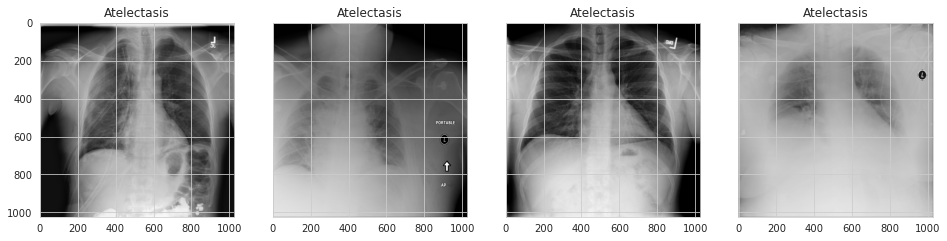

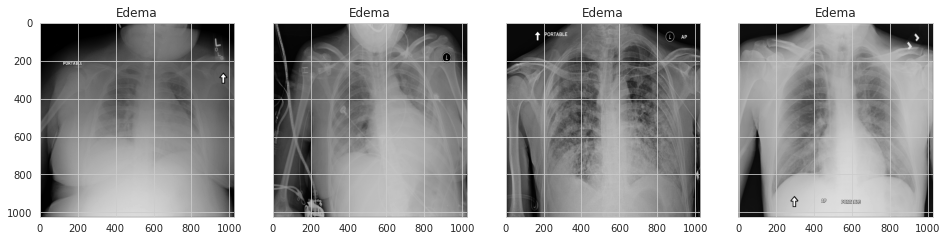

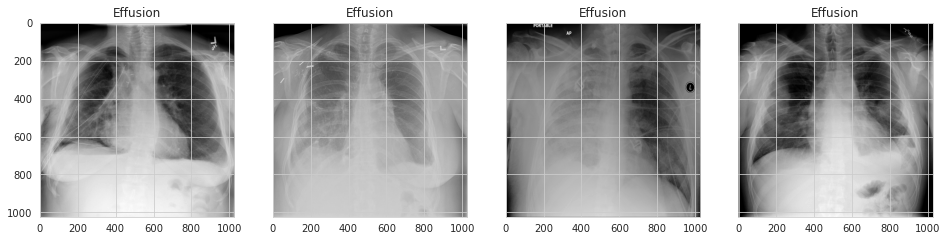

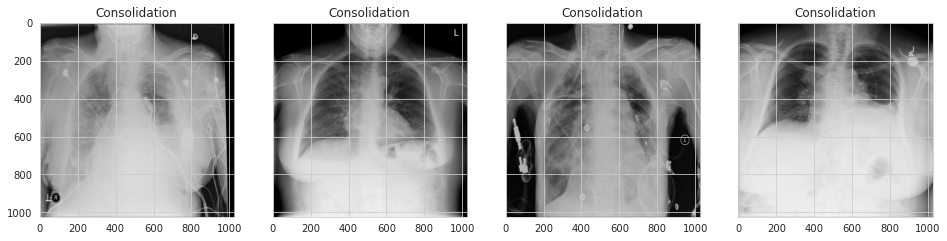

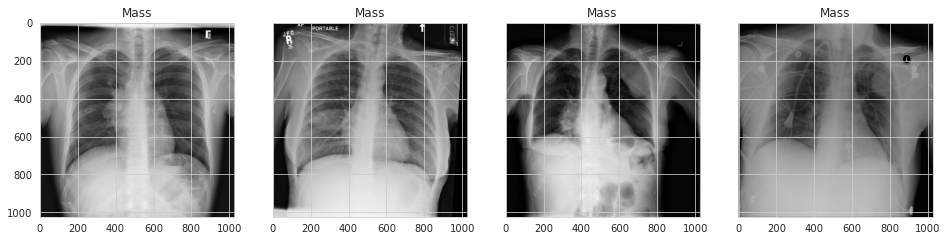

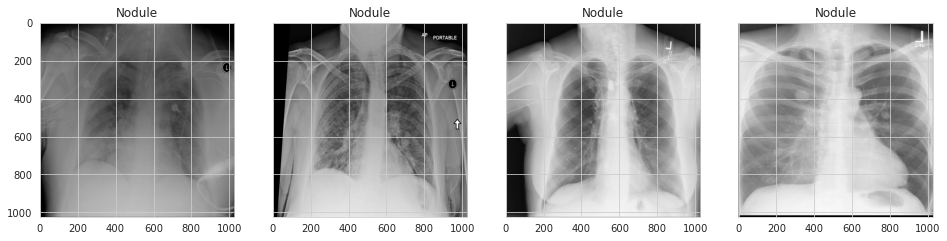

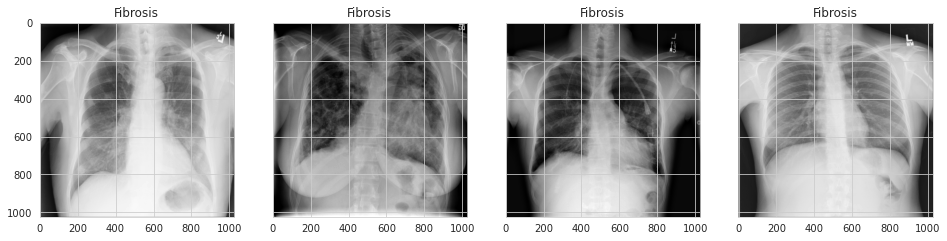

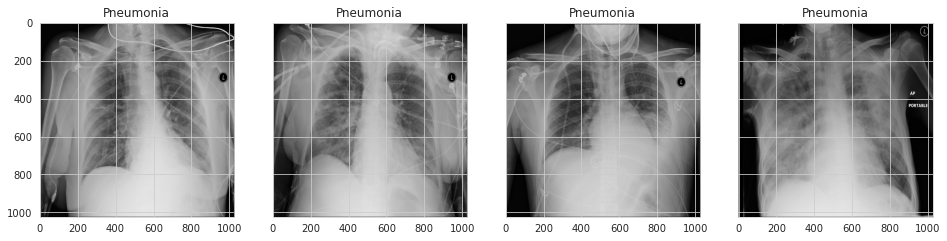

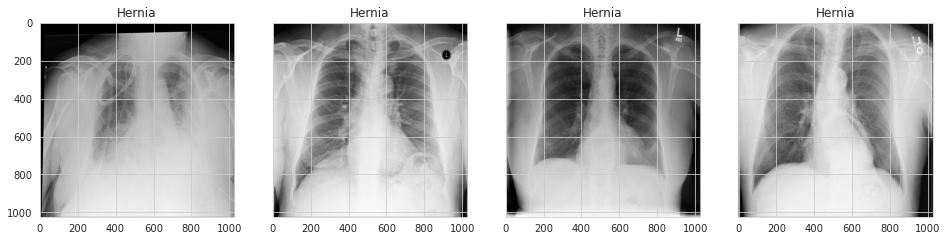

In [58]:
for pathology in pathologies:
    aux_path_df = df[df[pathology] == True]['Path']
    indexes = aux_path_df.index

    _, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 4))

    for i in range(4):
        r = int(np.random.rand() * len(indexes))
        index = indexes[r]

        path = aux_path_df[index]
        im = plt.imread(path)
        axes[i].set_title(pathology)
        axes[i].imshow(im, cmap='gray')

In [21]:
def get_heat_map_sample(_df):
    values = _df.values
    n_samples = len(_df)
    samples = np.zeros((n_samples, 1000, 1000))

    for i in range(n_samples):
        # Extract values
        row = values[i]
        # Get Xs
        x_1 = int(row[3])
        x_2 = int(row[3] + row[5])
        # Get Ys
        y_1 = int(row[4])
        y_2 = int(row[4] + row[6])
        # Modify sample
        samples[i, y_1:y_2, x_1:x_2] = 1
    
    return np.sum(samples, axis=0)

In [22]:
bounding_box_df = pd.read_csv('/data/BBox_List_2017.csv')

# Add new columns to ease processing
bounding_box_df['Path'] = bounding_box_df['Image Index'].apply(lambda x: glob(f'/data/images*/*/{x}')[0])
bounding_box_df['X'] = bounding_box_df['Bbox [x']
bounding_box_df['Y'] = bounding_box_df['y']
bounding_box_df['Width'] = bounding_box_df['w']
bounding_box_df['Height'] = bounding_box_df['h]']

# Drop old columns
dropable_columns = ['Bbox [x', 'y', 'w', 'h]', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8']
bounding_box_df = bounding_box_df.drop(dropable_columns, axis=1)

# Show dataframe
bounding_box_df.head()

,Image Index,Finding Label,Path,X,Y,Width,Height
0,00013118_008.png,Atelectasis,/data/images_006/images/00013118_008.png,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,/data/images_007/images/00014716_007.png,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,/data/images_012/images/00029817_009.png,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,/data/images_007/images/00014687_001.png,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,/data/images_008/images/00017877_001.png,660.067797,569.780787,200.677966,78.101695


In [23]:
bounding_box_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Image Index    984 non-null    object 
 1   Finding Label  984 non-null    object 
 2   Path           984 non-null    object 
 3   X              984 non-null    float64
 4   Y              984 non-null    float64
 5   Width          984 non-null    float64
 6   Height         984 non-null    float64
dtypes: float64(4), object(3)
memory usage: 53.9+ KB


In [24]:
bounding_box_df['Finding Label'].value_counts()

Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: Finding Label, dtype: int64

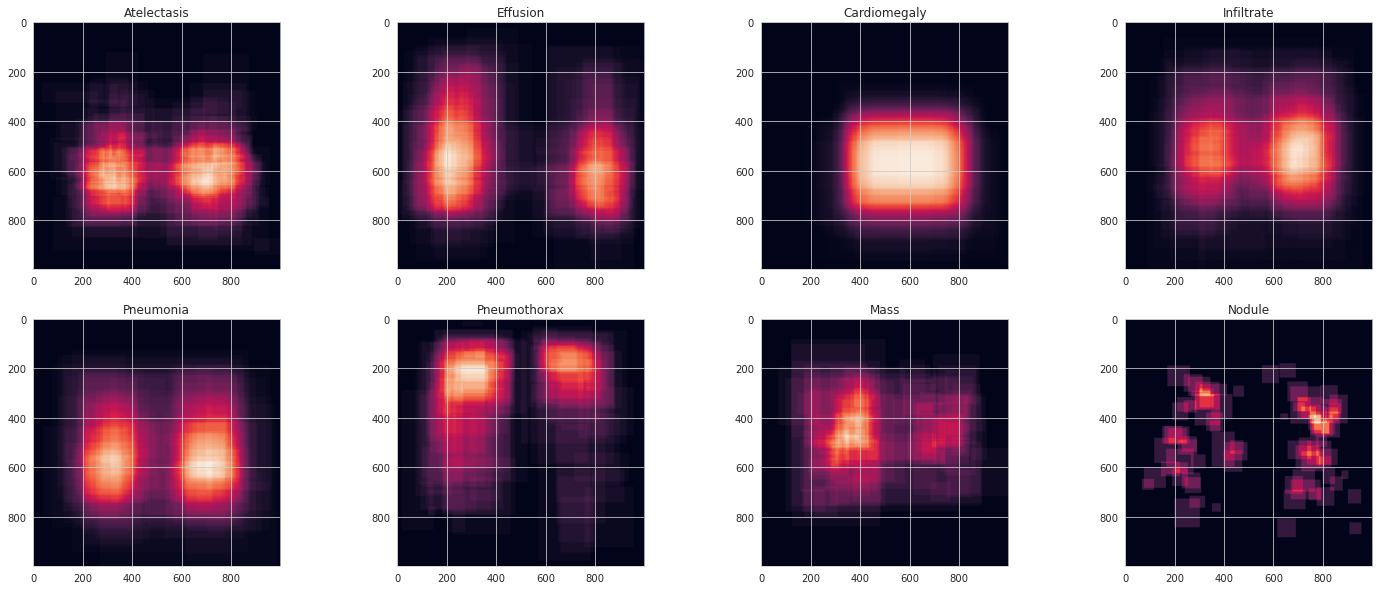

In [25]:
fig, axes = plt.subplots(2, 4, figsize=(25, 10))
axes = axes.flatten()

bb_pathologies = ['Atelectasis', 'Effusion', 'Cardiomegaly', 'Infiltrate', 'Pneumonia', 'Pneumothorax', 'Mass', 'Nodule']
for i in range(len(bb_pathologies)):
    # Get pathology from list
    pathology = bb_pathologies[i]
    # Extract rows having this pathology
    pathology_df = bounding_box_df[bounding_box_df['Finding Label'] == pathology]
    # Compute heat map
    heat_map = get_heat_map_sample(pathology_df)
    # Add to array
    axes[i].imshow(heat_map)
    axes[i].set_title(pathology)


_______________________________________

## Pneumonia Analysis

In [26]:
pneumonia_df = df[df['Pneumonia'] == True]
no_pneumonia_df = df[df['Pneumonia'] == False]
pneumonia_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Atelectasis,Edema,Effusion,Consolidation,Mass,Nodule,Fibrosis,Pneumonia,Hernia,Path
256,00001373_010.png,Cardiomegaly|Effusion|Pneumonia,10,1373,58,M,AP,3056,2544,0.139,...,False,False,True,False,False,False,False,True,False,/data/images_002/images/00001373_010.png
287,00001529_004.png,Consolidation|Infiltration|Pneumonia,4,1529,54,F,PA,2992,2991,0.143,...,False,False,False,True,False,False,False,True,False,/data/images_002/images/00001529_004.png
382,00001993_000.png,Infiltration|Nodule|Pneumonia,0,1993,11,F,PA,2048,2500,0.168,...,False,False,False,False,False,True,False,True,False,/data/images_002/images/00001993_000.png
723,00003789_000.png,Nodule|Pneumonia,0,3789,41,M,AP,2500,2048,0.171,...,False,False,False,False,False,True,False,True,False,/data/images_002/images/00003789_000.png
775,00004074_000.png,Mass|Nodule|Pneumonia,0,4074,47,M,PA,2500,2048,0.171,...,False,False,False,False,True,True,False,True,False,/data/images_003/images/00004074_000.png


Text(0.5, 1.0, 'Deseases Present without Pneumonia')

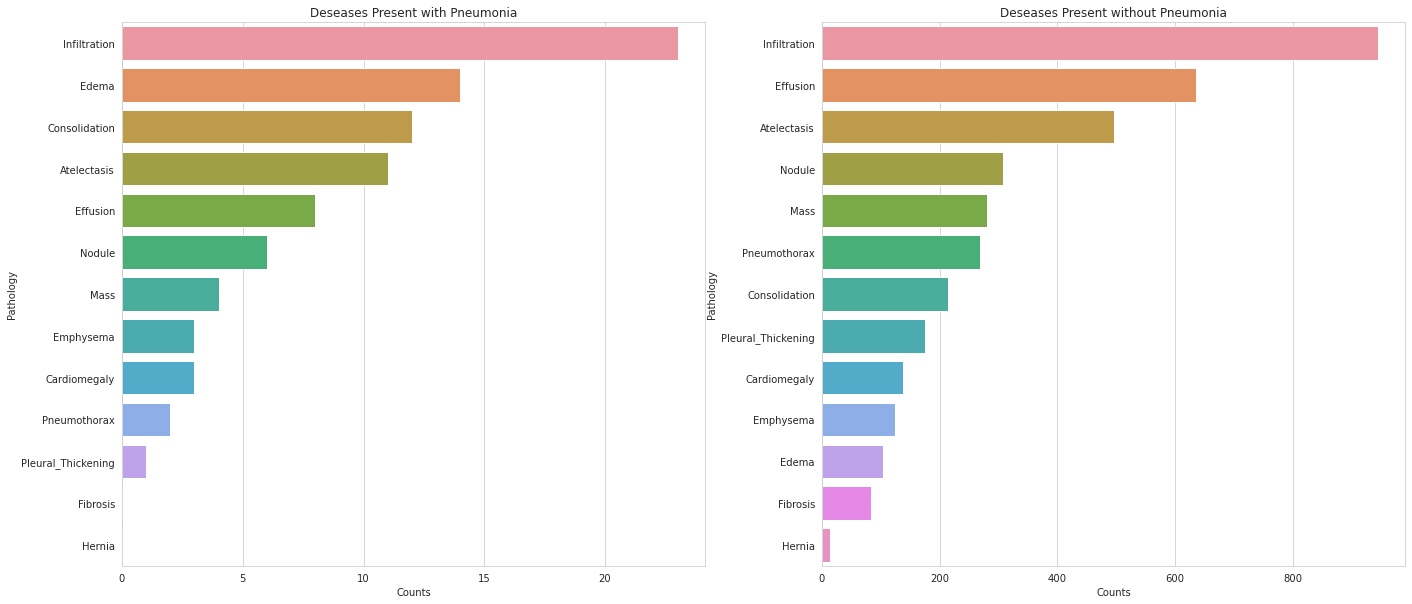

In [27]:
fig = plt.figure(figsize=(23, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

aux_1 = { 'Pathology': [], 'Counts': [] }
aux_2 = { 'Pathology': [], 'Counts': [] }

for pathology in pathologies:
    if pathology == 'No Finding' or pathology == 'Pneumonia': continue
    aux_1['Pathology'].append(pathology)
    aux_1['Counts'].append(len(pneumonia_df[pneumonia_df[pathology] == True]))
    
    aux_2['Pathology'].append(pathology)
    aux_2['Counts'].append(len(no_pneumonia_df[no_pneumonia_df[pathology] == True]))
    
aux_1_df = pd.DataFrame(aux_1).sort_values(by=['Counts'], ascending=False)
aux_2_df = pd.DataFrame(aux_2).sort_values(by=['Counts'], ascending=False)

sns.barplot(x='Counts', y='Pathology', data=aux_1_df, ax=ax1).set_title('Deseases Present with Pneumonia')
sns.barplot(x='Counts', y='Pathology', data=aux_2_df, ax=ax2).set_title('Deseases Present without Pneumonia')

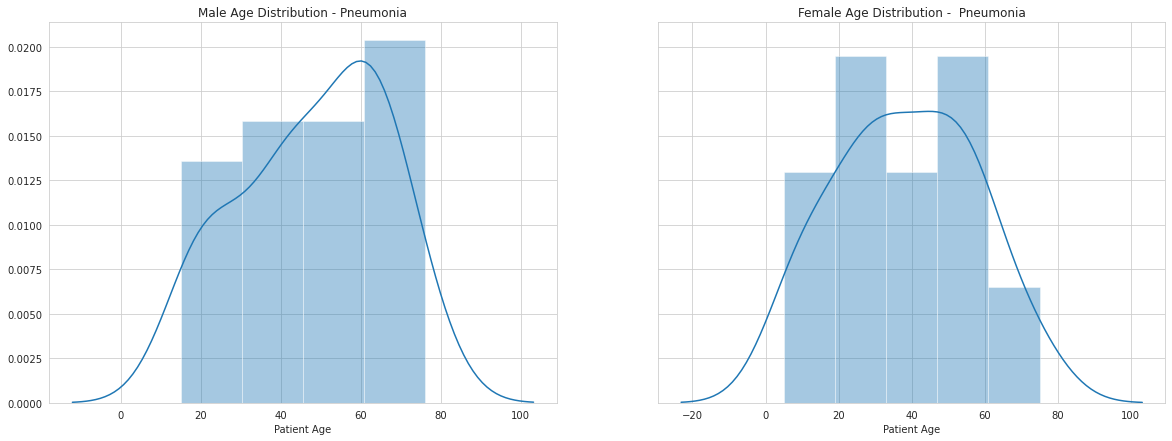

In [60]:
plot_distributions([
    { 'data': pneumonia_df[pneumonia_df['Patient Gender'] == 'M']['Patient Age'], 'title': 'Male Age Distribution - Pneumonia' },
    { 'data': pneumonia_df[pneumonia_df['Patient Gender'] == 'F']['Patient Age'], 'title': 'Female Age Distribution -  Pneumonia' }
])

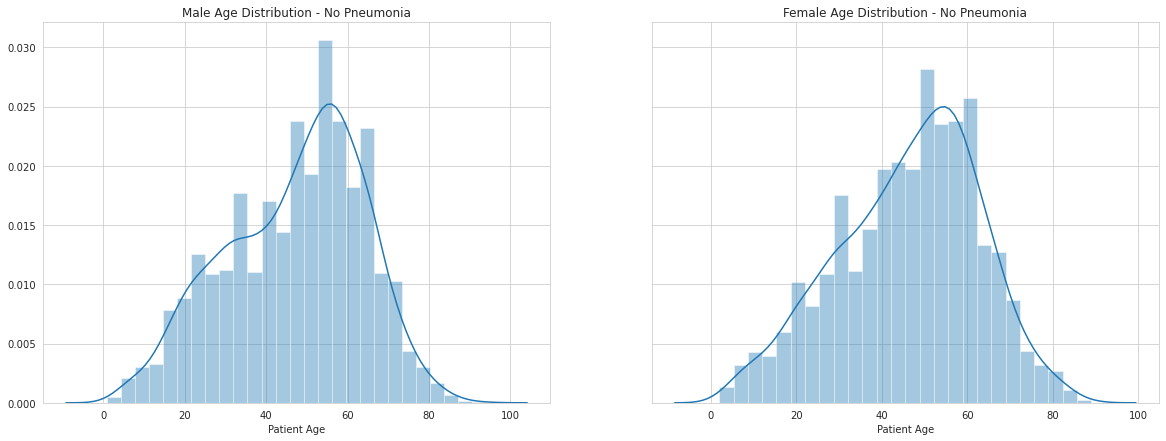

In [61]:
plot_distributions([
    { 'data': no_pneumonia_df[no_pneumonia_df['Patient Gender'] == 'M']['Patient Age'], 'title': 'Male Age Distribution - No Pneumonia' },
    { 'data': no_pneumonia_df[no_pneumonia_df['Patient Gender'] == 'F']['Patient Age'], 'title': 'Female Age Distribution - No Pneumonia' }
])